### 步驟 1：載入必要套件與資料

In [29]:
import pandas as pd
import numpy as np
import json
import re
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import threading
from jupyter_dash import JupyterDash
import plotly.express as px
import matplotlib.pyplot as plt

### 步驟 2：讀取資料集與資料擴增

In [2]:
df = pd.read_excel("資料集2 drink dataset.xlsx")
print(df.columns)

Index(['Class', 'Drink', 'Rank', 'Amount', 'Quantity', 'Count'], dtype='object')


#### 將 Amount 與 Quantity 字串解析為數值
#### Amount 是常態分佈參數，使用正規表示式抓取 (mean, std)
#### Quantity 是整數亂數區間，格式為 Random(low, high)

In [4]:
def parse_amount(val):
    match = re.match(r"\((\d+),\s*(\d+)\)", str(val))
    if match:
        mean, std = map(float, match.groups())
        return np.random.normal(loc=mean, scale=std)
    return np.nan

def parse_quantity(val):
    match = re.match(r"Random\((\d+),\s*(\d+)\)", str(val))
    if match:
        low, high = map(int, match.groups())
        return np.random.randint(low, high + 1)
    return np.nan    

#### 依每筆資料的 Count，隨機生成相對應筆數的新資料。
#### 新增欄位 Amount_val 和 Quantity_val 是解析後的數值

In [6]:
np.random.seed(42)
expanded_rows = []

for _, row in df.iterrows():
    count = int(row['Count'])
    for _ in range(count):
        new_row = {}
        new_row['Class'] = row['Class']
        new_row['Drink'] = row['Drink']
        new_row['Rank'] = row['Rank']
        new_row['Amount'] = row['Amount']
        new_row['Quantity'] = row['Quantity']
        # 依格式抽樣
        new_row['Amount_val'] = parse_amount(row['Amount'])
        new_row['Quantity_val'] = parse_quantity(row['Quantity'])
        expanded_rows.append(new_row)

# 建立 DataFrame
df = pd.DataFrame(expanded_rows)
print(df.head())
print(df.columns)

  Class Drink  Rank      Amount           Quantity  Amount_val  Quantity_val
0     A  Coke     8  (100, 200)  Random(500, 1000)  199.342831           606
1     A  Coke     8  (100, 200)  Random(500, 1000)   72.347140           571
2     A  Coke     8  (100, 200)  Random(500, 1000) -122.376024           966
3     A  Coke     8  (100, 200)  Random(500, 1000)  163.780437           714
4     A  Coke     8  (100, 200)  Random(500, 1000)  415.842563           649
Index(['Class', 'Drink', 'Rank', 'Amount', 'Quantity', 'Amount_val',
       'Quantity_val'],
      dtype='object')


### 步驟 3：數值欄位正規化

In [12]:
num_cols = ['Rank', 'Amount_val', 'Quantity_val']
scaler = MinMaxScaler()
X_num = scaler.fit_transform(df[num_cols])
X_num

array([[1.        , 0.23752364, 0.60560561],
       [1.        , 0.17612348, 0.57057057],
       [1.        , 0.08197829, 0.96596597],
       ...,
       [0.        , 0.52850594, 0.22722723],
       [0.        , 0.42968864, 0.15415415],
       [0.        , 0.27335803, 0.03303303]])

### 步驟 4：t-SNE

### 4-1. One-hot 編碼後 t-SNE
#### 將名目欄位 Drink 做 One-hot 編碼
#### 將其與數值特徵組合成新特徵矩陣，進行 t-SNE

In [14]:
encoder = OneHotEncoder(sparse_output=False)
X_onehot = encoder.fit_transform(df[['Drink']])
X1 = np.hstack([X_num, X_onehot])
tsne1 = TSNE(n_components=2, random_state=42, perplexity=100, init='pca')
X_tsne_onehot = tsne1.fit_transform(X1)

### 4-2. 使用人工設定 的t-SNE
#### 人工指定每對 Drink 之間的相似度

In [15]:
drink_similarity = {
    'Coke': {'Coke': 1.0, 'Pepsi': 0.9, 'Sprite': 0.9, '7Up': 0.9, 'Cappuccino': 0.1, 'Espresso': 0.1, 'Latte': 0.1, 'Mocha': 0.1},
    'Pepsi': {'Coke': 0.9, 'Pepsi': 1.0, 'Sprite': 0.9, '7Up': 0.9, 'Cappuccino': 0.1, 'Espresso': 0.1, 'Latte': 0.1, 'Mocha': 0.1},
    'Sprite': {'Coke': 0.9, 'Pepsi': 0.9, 'Sprite': 1.0, '7Up': 0.9, 'Cappuccino': 0.1, 'Espresso': 0.1, 'Latte': 0.1, 'Mocha': 0.1},
    '7Up': {'Coke': 0.9, 'Pepsi': 0.9, 'Sprite': 0.9, '7Up': 1.0, 'Cappuccino': 0.1, 'Espresso': 0.1, 'Latte': 0.1, 'Mocha': 0.1},
    'Cappuccino': {'Coke': 0.2, 'Pepsi': 0.2, 'Sprite': 0.2, '7Up': 0.2, 'Cappuccino': 1.0, 'Espresso': 0.8,'Latte': 0.8, 'Mocha': 0.8},
    'Espresso': {'Coke': 0.2, 'Pepsi': 0.2, 'Sprite': 0.2,  '7Up': 0.2, 'Cappuccino': 0.8, 'Espresso': 1.0, 'Latte': 0.8, 'Mocha': 0.8},
    'Latte': {'Coke': 0.2, 'Pepsi': 0.2, 'Sprite': 0.2, '7Up': 0.2, 'Cappuccino': 0.8, 'Espresso': 0.8, 'Latte': 1.0, 'Mocha': 0.8},
    'Mocha': {'Coke': 0.2, 'Pepsi': 0.2, 'Sprite': 0.2, '7Up': 0.2, 'Cappuccino': 0.8, 'Espresso': 0.8, 'Latte': 0.8, 'Mocha': 1.0},
}

# 相似度表轉為距離矩陣
n = len(df)
cat_dist = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim = drink_similarity[df['Drink'][i]][df['Drink'][j]]
        cat_dist[i, j] = 1 - sim        
num_dist = pairwise_distances(X_num, metric='euclidean')
#計算數值距離矩陣後也做正規化，保持與類別距離在同樣尺度。
num_dist = (num_dist - num_dist.min()) / (num_dist.max() - num_dist.min())
cat_dist = (cat_dist - cat_dist.min()) / (cat_dist.max() - cat_dist.min())
#結合兩者：70% 數值距離 + 30% 名目型距離（可調整權重）
total_dist = 0.7 * num_dist + 0.3 * cat_dist
tsne2 = TSNE(n_components=2, metric='precomputed', random_state=42, init='random', perplexity=100)
X_tsne_sim = tsne2.fit_transform(total_dist)

### 步驟 5：建立 Dash 互動式應用

#### 使用人工設定 的t-SNE結果

In [25]:
# 加入 t-SNE 結果欄位到 DataFrame
df_plot = df.copy()
df_plot['tsne1_x'] = X_tsne_onehot[:, 0]
df_plot['tsne1_y'] = X_tsne_onehot[:, 1]
df_plot['tsne2_x'] = X_tsne_sim[:, 0]
df_plot['tsne2_y'] = X_tsne_sim[:, 1]

# 建立 Dash 應用
app = Dash(__name__)

app.layout = html.Div([
    html.H3("t-SNE One-hot"),
    dcc.Graph(
        id='tsne-onehot',
        figure=px.scatter(
            df_plot,
            x='tsne1_x', y='tsne1_y',
            color='Class',
            custom_data=['Class', 'Drink', 'Rank', 'Amount', 'Quantity', 'Amount_val', 'Quantity_val']
        ).update_traces(marker_size=6, selector=dict(mode='markers'))
    ),
    
    html.H3("t-SNE with Distance Hierarchy"),
    dcc.Graph(
        id='tsne-sim',
        figure=px.scatter(
            df_plot,
            x='tsne2_x', y='tsne2_y',
            color='Class',
            custom_data=['Class', 'Drink', 'Rank', 'Amount', 'Quantity', 'Amount_val', 'Quantity_val']
        ).update_traces(marker_size=6, selector=dict(mode='markers'))
    ),
    
    html.H4("選取的資料點"),
    html.Pre(id='output-selected')
])

@app.callback(
    Output('output-selected', 'children'),
    [Input('tsne-onehot', 'selectedData'),
     Input('tsne-sim', 'selectedData')]
)
def display_selected_data(selected1, selected2):
    result = []
    
    for i, selected in enumerate([selected1, selected2]):
        if selected and "points" in selected:
            result.append(f"圖 {i+1} 圈選資料點：")
            for pt in selected["points"]:
                cd = pt["customdata"]
                result.append(f"- Class: {cd[0]}, Drink: {cd[1]}, Rank: {cd[2]}, Amount_val: {cd[5]:.2f}")
        else:
            result.append(f"圖 {i+1} 未圈選資料")
    
    return "\n".join(result)

if __name__ == '__main__':
    app.run(debug=True, port=8051)

### 步驟 6：可視化圖

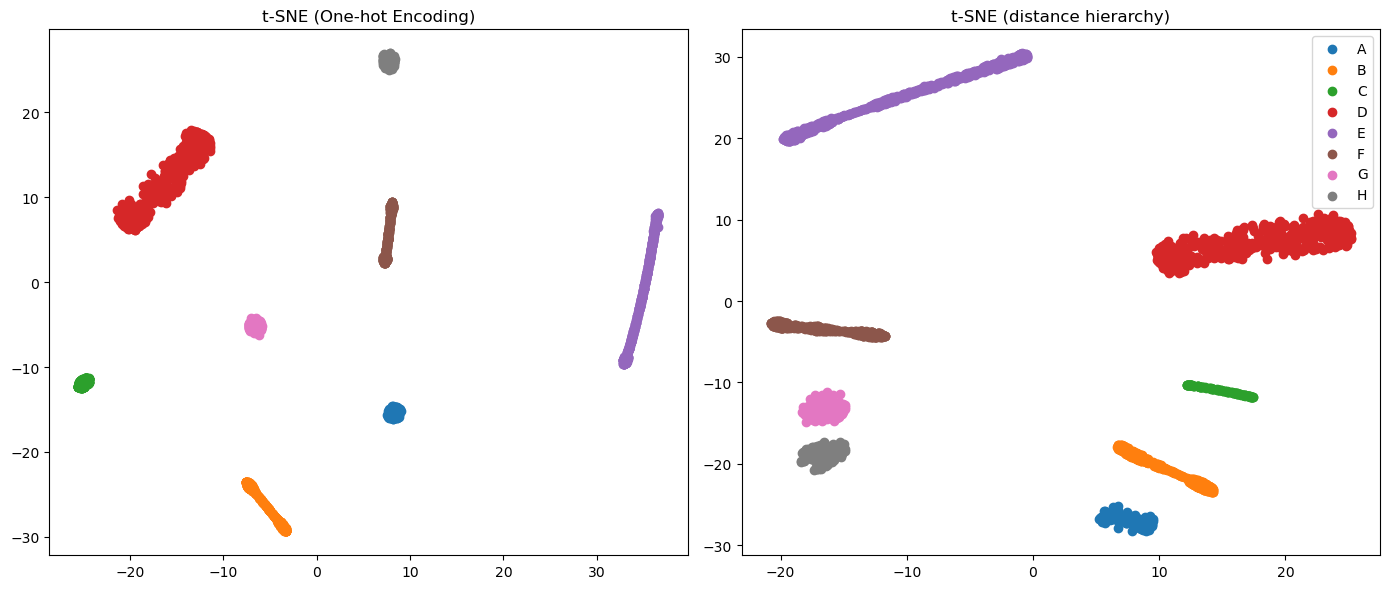

In [31]:
plt.figure(figsize=(14, 6))
# One-hot 結果
plt.subplot(1, 2, 1)
for label in df['Class'].unique():
    idx = df['Class'] == label
    plt.scatter(X_tsne_onehot[idx, 0], X_tsne_onehot[idx, 1], label=label)
plt.title("t-SNE (One-hot Encoding)")
#plt.xlim(-30,30)
#plt.ylim(-30, 30)

#  人工設定 結果
plt.subplot(1, 2, 2)
for label in df['Class'].unique():
    idx = df['Class'] == label
    plt.scatter(X_tsne_sim[idx, 0], X_tsne_sim[idx, 1], label=label)
plt.title("t-SNE (distance hierarchy)")
#plt.xlim(-30, 30)
#plt.ylim(-30, 30)

plt.tight_layout()
plt.legend()
plt.show()